In [1]:
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Literal

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import argmax, concatenate, random, unravel_index, vstack, linspace, pi
from pandas import DataFrame, concat, read_csv, set_option, to_datetime
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

set_option("display.max_columns", None)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (20, 12)

COLUMNS: list[str] = [
	"timestamp",
	"activity",
	"heart_rate",
	*[
		f"IMU_{body_part}_{suffix}"
		for body_part in ["hand", "chest", "ankle"]
		for suffix in [
			"temp_C",
			*[
				f"{scalar}_{axis}"
				for scalar in ["acc16g_ms^-2", "acc6g_ms^-2", "gyro_rad/s", "mag_μT"]
				for axis in ["x", "y", "z"]
			],
			*[f"orient_{x}" for x in range(1, 5)],
		]
	],
]


@dataclass
class PlotConfig:
	"""Centralized plot styling configuration."""

	selected_color: str = "#e74c3c"
	training_color: str = "#3498db"
	selected_alpha: float = 0.6
	training_alpha: float = 0.2
	selected_size: int = 50
	training_size: int = 10
	dpi: int = 300

	def get_color(self, is_selected: bool) -> str:
		return self.selected_color if is_selected else self.training_color

	def get_alpha(self, is_selected: bool) -> float:
		return self.selected_alpha if is_selected else self.training_alpha

	def get_size(self, is_selected: bool) -> int:
		return self.selected_size if is_selected else self.training_size


In [2]:
def read_w_log(path: Path, filename: str) -> tuple[DataFrame, str]:
	"""
	The IMU sensory data contains the following columns:
	- 1 temperature (°C)
	- 2...4 3D-acceleration data (ms^-2), scale: ±16g, resolution: 13-bit
	- 5...7 3D-acceleration data (ms^-2), scale: ±6g, resolution: 13-bit*
	- 8...10 3D-gyroscope data (rad/s)
	- 11...13 3D-magnetometer data (μT)
	- 14...17 orientation (invalid in this data collection)

	* This accelerometer is not precisely calibrated with the first one. Moreover, due
	to high impacts caused by certain movements (e.g. during running) with acceleration
	over 6g, it gets saturated sometimes. Therefore, the use of the data from the first
	accelerometer (with the scale of ±16g) is recommended.
	"""
	print(f"Reading: {filename}", end="\r")
	df = read_csv(os.path.join(path, filename), sep=r"\s+", header=None)
	df.columns = COLUMNS
	return (
		df.loc[
			:,
			~df.columns.str.contains("orient") & ~df.columns.str.contains("acc6g"),
		],
		filename.split(".")[0][-2:],
	)


def handle_nans(df: DataFrame) -> DataFrame:
	"""
	Handles NaN values in the sensor data with a time-series-aware strategy.

	- First, forward-fills to propagate the last valid observation.
	- Then, uses linear interpolation for short gaps.
	- Finally, drops any rows where sensor data is still missing.

	Args:
		df: The input DataFrame with potential NaN values.

	Returns:
		DataFrame with NaNs handled.
	"""
	# For IMU data: linear interpolation for short gaps, drop for long gaps
	for col in (imu_cols := [col for col in df.columns if col.startswith("IMU_")]):
		# Forward fill first (sensor readings typically persist briefly)
		df.loc[:, col] = df[col].ffill(limit=2)
		# Only interpolate if gap is ≤ 5 samples (0.05s at 100Hz)
		# IMU gaps can be interpolated without significant information loss.
		df.loc[:, col] = df[col].interpolate("linear", limit=5, limit_direction="both")
	# Drop rows where ANY IMU sensor still has NaN (likely sensor disconnection)
	return df.dropna(subset=imu_cols)


def normalize_features(data: DataFrame) -> DataFrame:
	"""
	Normalize features using training set statistics

	Args:
		X_train (Dataframe): training data
		X_test (Dataframe): testing data

	Returns:
		tuple[DataFrame, DataFrame]: scaled train and test data
	"""
	# Use RobustScaler for IMU data (less sensitive to outliers)
	if imu_columns := [col for col in data.columns if col.startswith("IMU_")]:
		data.loc[:, imu_columns] = RobustScaler().fit_transform(data[imu_columns])

	return data

In [3]:
class ActivityAnalyzer:
	"""Handles all activity analysis and visualization logic."""

	def __init__(
		self, data: DataFrame, labels: DataFrame, selected_activities: list[int]
	):
		self.df = data.merge(labels, how="left", on="id")
		self.selected = selected_activities
		self.imu_cols = [col for col in data.columns if col.startswith("IMU_")]
		self.config = PlotConfig()

	def is_selected(self, activity: int) -> bool:
		"""Check if activity is in selected list."""
		return activity in self.selected

	def get_activity_data(self, activity: int) -> DataFrame:
		"""Get data for specific activity."""
		return self.df[self.df["activity"] == activity][self.imu_cols]

	def get_activities(self) -> list[int]:
		"""Get sorted list of all activities."""
		return sorted(self.df["activity"].unique())

	def calculate_metric(self, metric_fn: Callable) -> DataFrame:
		"""Calculate any metric for all activities."""
		return DataFrame(
			[
				{
					"Activity": f"Act {activity}",
					"activity_id": activity,
					"Value": metric_fn(self.get_activity_data(activity)),
					"Type": "Selected (Novel)"
					if self.is_selected(activity)
					else "Training (Normal)",
				}
				for activity in self.get_activities()
			]
		)

### _Mod proposal_: **Activity-Based Splitting**

> In novelty detection, you want to detect unseen patterns. If the same subject appears in both train and test, the model learns subject-specific characteristics, which won't generalize to new users.

In [4]:
def load_data(path: Path, norm_features: bool = True) -> tuple[DataFrame, DataFrame]:
	data, labels = [], []
	for df, subject in [  # all protocol files
		read_w_log(path, filename)
		for filename in os.listdir(path)
		if filename.endswith(".dat")
	]:  # droping rope jumping (24) cause only subject 9 does this activity
		df = handle_nans(df[~df["activity"].isin([0, 24])])
		df["subject"] = str(subject)
		df["timestamp"] = to_datetime(df["timestamp"], unit="s").dt.time
		df["id"] = df["subject"] + "_" + df["timestamp"].astype(str)

		data.append(df.drop(columns=["activity", "heart_rate"]))
		labels.append(df[["id", "activity"]])  # Index & Activity

	data, labels = concat(data), concat(labels)
	data["subject"] = data["subject"].astype("category")
	labels["activity"] = labels["activity"].astype("category")

	return (normalize_features(data), labels) if norm_features else (data, labels)

In [5]:
data, labels = load_data(Path("../data/PAMAP2_Dataset/Protocol/"))

data.to_csv("../data/PAMAP2/data.csv", index=False)
labels.to_csv("../data/PAMAP2/labels.csv", index=False)

df = data.merge(labels, how="left", on="id")
df.head()

,timestamp,IMU_hand_temp_C,IMU_hand_acc16g_ms^-2_x,IMU_hand_acc16g_ms^-2_y,IMU_hand_acc16g_ms^-2_z,IMU_hand_gyro_rad/s_x,IMU_hand_gyro_rad/s_y,IMU_hand_gyro_rad/s_z,IMU_hand_mag_μT_x,IMU_hand_mag_μT_y,IMU_hand_mag_μT_z,IMU_chest_temp_C,IMU_chest_acc16g_ms^-2_x,IMU_chest_acc16g_ms^-2_y,IMU_chest_acc16g_ms^-2_z,IMU_chest_gyro_rad/s_x,IMU_chest_gyro_rad/s_y,IMU_chest_gyro_rad/s_z,IMU_chest_mag_μT_x,IMU_chest_mag_μT_y,IMU_chest_mag_μT_z,IMU_ankle_temp_C,IMU_ankle_acc16g_ms^-2_x,IMU_ankle_acc16g_ms^-2_y,IMU_ankle_acc16g_ms^-2_z,IMU_ankle_gyro_rad/s_x,IMU_ankle_gyro_rad/s_y,IMU_ankle_gyro_rad/s_z,IMU_ankle_mag_μT_x,IMU_ankle_mag_μT_y,IMU_ankle_mag_μT_z,subject,id,activity
0,00:00:37.660000,-1.25,0.974324,0.899983,0.395616,0.002293,0.068537,-0.007749,-0.406895,-1.700620,0.155325,-1.971429,-0.198360,0.117609,-0.041317,0.157855,0.053823,-0.171265,-0.109981,-1.096486,1.393191,-2.208333,0.114480,-0.396282,0.921056,-0.005724,-0.111156,0.008245,-1.140138,-1.264727,-2.839935,01,01_00:00:37.660000,1
1,00:00:37.670000,-1.25,0.983981,0.785730,0.425154,-0.240880,0.042738,-0.005510,-0.388014,-1.701462,0.121321,-1.971429,-0.151300,0.117547,-0.041026,0.076630,-0.084299,-0.205035,-0.092728,-1.082746,1.368834,-2.208333,0.090861,-0.405694,0.878668,0.050452,0.023558,0.016652,-1.131150,-1.246630,-2.839787,01,01_00:00:37.670000,1
2,00:00:37.680000,-1.25,0.983848,0.685760,0.439957,-0.337781,0.012322,0.008934,-0.403323,-1.683308,0.172341,-1.971429,-0.108353,0.137357,-0.089858,-0.020746,0.127871,-0.140963,-0.115712,-1.096109,1.384954,-2.208333,0.090116,-0.415331,0.864642,-0.125430,-0.227299,-0.004863,-1.108279,-1.228813,-2.848883,01,01_00:00:37.680000,1
3,00:00:37.690000,-1.25,0.974664,0.685995,0.454220,-0.271760,0.029038,0.026407,-0.378037,-1.684514,0.134029,-1.971429,-0.129059,0.137669,-0.057288,0.066945,-0.166243,-0.277369,-0.122420,-1.060551,1.372647,-2.208333,0.071286,-0.396161,0.920774,-0.116434,-0.069460,0.058031,-1.125878,-1.272686,-2.821851,01,01_00:00:37.690000,1
4,00:00:37.700000,-1.25,0.985127,0.707652,0.490553,-0.092686,-0.050666,0.014159,-0.400390,-1.676160,0.151311,-1.971429,-0.057762,0.137642,-0.048672,-0.012765,-0.047279,-0.106725,-0.115362,-1.095488,1.348153,-2.208333,0.135965,-0.406062,0.921282,-0.010590,-0.210641,-0.007720,-1.102604,-1.273341,-2.822028,01,01_00:00:37.700000,1


In [6]:
def select_most_distinct_activities(
	data: DataFrame,
	labels: DataFrame,
	n_activities: int = 3,
	method: Literal["pca", "statistical", "variance"] = "pca",
) -> list[int]:
	"""
	Select the most distinct activities based on pairwise feature distances.

	Uses a greedy algorithm to maximize separation between selected activities:
	1. Start with the two activities that are furthest apart
	2. If selecting 3, add the activity with maximum minimum distance to the first two

	Args:
		data: Feature DataFrame
		labels: Labels DataFrame with 'id' and 'activity' columns
		n_activities: Number of activities to select (2 or 3)
		method: Method to use for activity representation:
			- 'pca': Use principal components (captures main movement patterns)
			- 'statistical': Use mean, std, and quartiles (robust statistics)
			- 'variance': Use variance and energy (good for dynamic activities)

	Returns:
		List of activity IDs representing the most distinct activities
	"""
	print(f"\n🔍 Selecting {n_activities} most distinct activities using '{method}'...")
	df = data.merge(labels, how="left", on="id")
	imu_cols = [col for col in data.columns if col.startswith("IMU_")]

	activity_stats = {}
	for activity in df["activity"].unique():
		activity_data = df[df["activity"] == activity][imu_cols]
		if method == "pca":  # Reduce dimensionality and capture main characteristics
			activity_stats[activity] = (
				PCA(n_components=min(10, len(imu_cols), len(activity_data)))
				.fit_transform(activity_data)  # PCA components as activity signature
				.mean(axis=0)
			)
		elif method == "statistical":
			activity_stats[activity] = concatenate(
				[  # Statistical features (more robust to outliers)
					activity_data.mean().values,
					activity_data.std().values,
					activity_data.quantile(0.25).values,
					activity_data.quantile(0.75).values,
				]
			)
		elif method == "variance":
			activity_stats[activity] = concatenate(
				[  # Variance and energy characteristics (good for dynamic activities)
					activity_data.var().values,
					activity_data.abs().mean().values,  # Mean absolute value (energy)
				]
			)
	activities = list(activity_stats.keys())
	distances = squareform(  # Calculate pairwise distances between activities
		pdist(vstack([activity_stats[act] for act in activities]), metric="euclidean")
	)
	selected_indices = []  # Greedy selection algorithm
	# Start with the pair that has maximum distance
	max_dist_idx = unravel_index(distances.argmax(), distances.shape)
	selected_indices.extend([max_dist_idx[0], max_dist_idx[1]])
	# If a third activity is needed, select the one with maximum minimum distance
	if n_activities == 3:
		remaining_indices = [
			i for i in range(len(activities)) if i not in selected_indices
		]
		# Select the activity with maximum minimum distance (most distinct from both)
		selected_indices.append(
			remaining_indices[
				argmax(
					[  # Find minimum distance to any already selected activity
						min(distances[idx, sel_idx] for sel_idx in selected_indices)
						for idx in remaining_indices
					]
				)
			]
		)
	print(f"\n✅ Selected {n_activities} most distinct activities:")
	for i, act in enumerate(
		selected_activities := [activities[i] for i in selected_indices], 1
	):
		print(f"  {i}. Activity {act}: {(df['activity'] == act).sum():,} samples")

	print("\n📏 Pairwise distances between selected activities:")
	for i in range(len(selected_indices)):
		for j in range(i + 1, len(selected_indices)):
			print(
				f"Activity {selected_activities[i]} ↔ Activity {selected_activities[j]}"
				f": {distances[selected_indices[i], selected_indices[j]]:.2f}"
			)
	return selected_activities

In [7]:
def activity_based_split(
	data: DataFrame,
	labels: DataFrame,
	test_activities: list[int] | None = None,
	n_distinct: int = 2,
	method: Literal["pca", "statistical", "variance"] = "pca",
	val_size: float = 0.2,
	random_state: int = 42,
) -> tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
	"""
	Split data into train/val/test sets based on activities for novelty detection.

	Strategy:
	- Test set: Contains ONLY the most distinct activities (novel/unseen)
	- Train set: Contains all other activities (normal behavior)
	- Val set: Split from train set, maintains same activity distribution

	This ensures the model is evaluated on truly novel activities during testing.

	Args:
		data: Feature DataFrame
		labels: Labels DataFrame with 'id' and 'activity' columns
		test_activities: Optional list of activity IDs to use as test set.
			If None, automatically selects using distinctiveness algorithm.
		n_distinct: Number of activities to auto-select (if test_activities=None)
		method: How to calculate distinctiveness. 'pca', 'statistical' or 'variance'
		val_size: Proportion of train data to use for validation (e.g., 0.2 = 20%)
		random_state: Random seed for reproducibility

	Returns:
		tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
	"""
	if test_activities is None:  # Auto-select distinct activities if not provided
		test_activities = select_most_distinct_activities(
			data, labels, n_activities=n_distinct, method=method
		)
	df = data.merge(labels, how="left", on="id")  # Merge data and labels
	# Split based on activities
	test_mask = df["activity"].isin(test_activities)
	train_val_df = df[~test_mask].copy()
	test_df = df[test_mask].copy()
	# Split train_val into train and validation
	# Stratify by subject to maintain subject distribution
	train_df, val_df = train_test_split(
		train_val_df,
		test_size=val_size,
		random_state=random_state,
		stratify=train_val_df["subject"],  # Maintain subject distribution
	)
	# Separate features and labels
	feature_cols = [col for col in data.columns if col != "id"]

	X_train = train_df[feature_cols].reset_index(drop=True)
	X_val = val_df[feature_cols].reset_index(drop=True)
	X_test = test_df[feature_cols].reset_index(drop=True)

	y_train = train_df[["id", "activity"]].reset_index(drop=True)
	y_val = val_df[["id", "activity"]].reset_index(drop=True)
	y_test = test_df[["id", "activity"]].reset_index(drop=True)

	return X_train, X_val, X_test, y_train, y_val, y_test  # type: ignore

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = activity_based_split(
	data=data, labels=labels, n_distinct=2, method="pca", val_size=0.2, random_state=42
)
output_dir = Path("../data/PAMAP2/splits/")
output_dir.mkdir(parents=True, exist_ok=True)

X_train.to_csv(output_dir / "X_train.csv", index=False)
X_val.to_csv(output_dir / "X_val.csv", index=False)
X_test.to_csv(output_dir / "X_test.csv", index=False)

y_train.to_csv(output_dir / "y_train.csv", index=False)
y_val.to_csv(output_dir / "y_val.csv", index=False)
y_test.to_csv(output_dir / "y_test.csv", index=False)


🔍 Selecting 2 most distinct activities using 'pca'...

✅ Selected 2 most distinct activities:
  1. Activity 7: 188,107 samples
  2. Activity 5: 98,199 samples

📏 Pairwise distances between selected activities:
Activity 7 ↔ Activity 5: 0.00


In [9]:
def plot_projection_2d(ax, analyzer: ActivityAnalyzer, projection_type: str = "pca"):
	"""Generic 2D projection plot (PCA or t-SNE)."""
	if projection_type == "pca":
		reducer = PCA(n_components=2, random_state=42)
		coords = reducer.fit_transform(analyzer.df[analyzer.imu_cols])
		variance = reducer.explained_variance_ratio_
		xlabel = f"PC1 ({variance[0]:.1%} variance)"
		ylabel = f"PC2 ({variance[1]:.1%} variance)"
		title = "PCA Projection (2D)"
	else:  # t-SNE
		sample_size = min(10000, len(analyzer.df))
		sample_idx = random.choice(len(analyzer.df), sample_size, replace=False)
		df_sample = analyzer.df.iloc[sample_idx]
		reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
		coords = reducer.fit_transform(df_sample[analyzer.imu_cols])
		analyzer.df = df_sample  # Temporary override for plotting
		xlabel, ylabel = "t-SNE Dimension 1", "t-SNE Dimension 2"
		title = f"t-SNE Projection ({sample_size:,} samples)"

	for activity in analyzer.get_activities():
		mask = analyzer.df["activity"] == activity
		is_sel = analyzer.is_selected(activity)
		ax.scatter(
			coords[mask, 0],
			coords[mask, 1],
			label=f"Activity {activity}",
			alpha=analyzer.config.get_alpha(is_sel),
			s=analyzer.config.get_size(is_sel),
			edgecolors="black" if is_sel else "none",
			linewidths=1.5 if is_sel else 0,
		)
	ax.set_xlabel(xlabel)
	ax.set_ylabel(ylabel)
	ax.set_title(f"{title}\nSelected activities highlighted", fontweight="bold")
	ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
	ax.grid(alpha=0.3)


def plot_distance_heatmap(ax, analyzer: ActivityAnalyzer):
	"""Activity distance matrix heatmap."""
	# Calculate centroids and distances
	activities = analyzer.get_activities()
	sns.heatmap(
		squareform(
			pdist(
				vstack(
					[
						analyzer.get_activity_data(act).mean().values
						for act in activities
					]
				),
				metric="euclidean",
			)
		),
		xticklabels=activities,
		yticklabels=activities,
		annot=True,
		fmt=".1f",
		cmap="YlOrRd",
		ax=ax,
		cbar_kws={"label": "Euclidean Distance"},
		square=True,
	)
	for i, act in enumerate(activities):  # Highlight selected activities
		if analyzer.is_selected(act):
			n = len(activities)
			ax.add_patch(
				plt.Rectangle((i, 0), 1, n, fill=False, edgecolor="blue", lw=3)  # type: ignore
			)
			ax.add_patch(
				plt.Rectangle((0, i), n, 1, fill=False, edgecolor="blue", lw=3)  # type: ignore
			)
	ax.set_title(
		"Pairwise Activity Distances\nBlue boxes = selected", fontweight="bold"
	)


def plot_metric_barh(
	ax, analyzer: ActivityAnalyzer, metric_fn: Callable, title: str, xlabel: str
):
	"""Generic horizontal bar plot for any metric."""
	df_metric = analyzer.calculate_metric(metric_fn).sort_values(
		"Value", ascending=False
	)
	ax.barh(
		df_metric["Activity"],
		df_metric["Value"],
		color=[
			analyzer.config.get_color(analyzer.is_selected(row["activity_id"]))  # type: ignore
			for _, row in df_metric.iterrows()
		],
		alpha=0.7,
	)
	ax.set_xlabel(xlabel)
	ax.set_ylabel("Activity")
	ax.set_title(f"{title}\nRed = Selected, Blue = Training", fontweight="bold")
	ax.grid(axis="x", alpha=0.3)


def plot_dendrogram(ax, analyzer: ActivityAnalyzer):
	"""Hierarchical clustering dendrogram."""
	activities = analyzer.get_activities()
	linkage_matrix = linkage(
		vstack([analyzer.get_activity_data(act).mean().values for act in activities]),
		method="ward",
	)
	dendrogram(
		linkage_matrix,
		labels=[f"Act {act}" for act in activities],
		ax=ax,
		leaf_font_size=10,
		color_threshold=0.7 * max(linkage_matrix[:, 2]),
	)
	for label in ax.get_xticklabels():  # Color selected activities
		act_num = int(label.get_text().split()[1])
		if analyzer.is_selected(act_num):
			label.set_color("red")
			label.set_weight("bold")

	ax.set_title("Hierarchical Clustering\nRed = Selected", fontweight="bold")
	ax.set_ylabel("Distance")
	ax.set_xlabel("Activity")


def plot_violin_comparison(ax, analyzer: ActivityAnalyzer):
	"""Violin plot comparing feature distributions."""
	sample_features = analyzer.imu_cols[:6]

	plot_data = []
	for feature in sample_features:
		for activity in analyzer.get_activities():
			samples = analyzer.df[analyzer.df["activity"] == activity][feature]
			plot_data.extend(
				[
					{
						"Feature": feature.split("_")[-1][:8],
						"Value": val,
						"Type": "Selected"
						if analyzer.is_selected(activity)
						else "Training",
					}
					for val in samples.sample(min(100, len(samples)), random_state=42)
				]
			)
	sns.violinplot(
		data=DataFrame(plot_data),
		x="Feature",
		y="Value",
		hue="Type",
		split=True,
		ax=ax,
		palette={
			"Selected": analyzer.config.selected_color,
			"Training": analyzer.config.training_color,
		},
		alpha=0.7,
	)
	ax.set_title(
		"Feature Distribution Comparison\nSelected vs Training", fontweight="bold"
	)
	ax.set_xlabel("Feature (first 6)")
	ax.tick_params(axis="x", rotation=45)
	ax.legend(title="Activity Type")
	ax.grid(alpha=0.3)


def plot_stats_table(ax, analyzer: ActivityAnalyzer):
	"""Summary statistics table."""
	ax.axis("off")

	stats_data = []
	for activity in analyzer.get_activities():
		data = analyzer.get_activity_data(activity)
		stats_data.append(
			[
				f"Act {activity}",
				f"{len(data):,}",
				f"{data.mean().mean():.2f}",
				f"{data.var().mean():.2f}",
				"✓" if analyzer.is_selected(activity) else "",
			]
		)
	table = ax.table(
		cellText=stats_data,
		colLabels=["Activity", "Samples", "Mean", "Variance", "Selected"],
		cellLoc="center",
		loc="center",
		colWidths=[0.15, 0.2, 0.2, 0.2, 0.15],
	)
	table.auto_set_font_size(False)
	table.set_fontsize(9)
	table.scale(1, 2)

	for i in range(5):  # Style header
		table[(0, i)].set_facecolor("#34495e")
		table[(0, i)].set_text_props(weight="bold", color="white")

	for i, activity in enumerate(analyzer.get_activities(), 1):
		if analyzer.is_selected(activity):  # Highlight selected rows
			for j in range(5):
				table[(i, j)].set_facecolor("#ffcccc")
	ax.set_title(
		"Activity Statistics Summary\nHighlighted = Selected", fontweight="bold", pad=20
	)

In [10]:
def plot_activity_distinctiveness(
	data: DataFrame,
	labels: DataFrame,
	selected_activities: list[int],
	method: str = "pca",
	output_dir: Path | None = None,
) -> None:
	"""
	Create comprehensive visualizations showing activity distinctiveness.

	Args:
		data: Feature DataFrame
		labels: Labels DataFrame
		selected_activities: List of selected activity IDs
		method: Method used for selection
		output_dir: Optional directory to save plots
	"""
	analyzer = ActivityAnalyzer(data, labels, selected_activities)
	fig = plt.figure(figsize=(20, 12))
	gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

	for grid_pos, plot_fn in [  # Define plot layout with corresponding functions
		(gs[0, 0], lambda ax: plot_projection_2d(ax, analyzer, "pca")),
		(gs[0, 1], lambda ax: plot_projection_2d(ax, analyzer, "tsne")),
		(gs[0, 2], lambda ax: plot_distance_heatmap(ax, analyzer)),
		(
			gs[1, 0],
			lambda ax: plot_metric_barh(
				ax,
				analyzer,
				lambda d: d.var().mean(),
				"Feature Variance by Activity",
				"Mean Feature Variance",
			),
		),
		(
			gs[1, 1],
			lambda ax: plot_metric_barh(
				ax,
				analyzer,
				lambda d: d.abs().mean().mean(),
				"Energy Level by Activity",
				"Mean Energy (|x|)",
			),
		),
		(gs[1, 2], lambda ax: plot_dendrogram(ax, analyzer)),
		(
			gs[2, 0],
			lambda ax: plot_metric_barh(
				ax,
				analyzer,
				lambda d: len(d),
				"Sample Count by Activity",
				"Number of Samples",
			),
		),
		(gs[2, 1], lambda ax: plot_violin_comparison(ax, analyzer)),
		(gs[2, 2], lambda ax: plot_stats_table(ax, analyzer)),
	]:
		plot_fn(fig.add_subplot(grid_pos))

	fig.suptitle(
		f"Activity Distinctiveness Analysis - Method: {method.upper()}\n"
		f"Selected Activities: {selected_activities}",
		fontsize=16,
		fontweight="bold",
		y=0.98,
	)
	plt.tight_layout()

	if output_dir:
		output_dir = Path(output_dir)
		output_dir.mkdir(parents=True, exist_ok=True)
		filepath = output_dir / f"activity_distinctiveness_{method}.png"
		plt.savefig(filepath, dpi=analyzer.config.dpi, bbox_inches="tight")
		print(f"📊 Plot saved to: {filepath}")

	plt.show()


def plot_3d_activity_space(
	data: DataFrame,
	labels: DataFrame,
	selected_activities: list[int],
	output_dir: Path | None = None,
) -> None:
	"""Create 3D PCA visualization."""
	analyzer = ActivityAnalyzer(data, labels, selected_activities)

	pca_3d = PCA(n_components=3, random_state=42)
	coords = pca_3d.fit_transform(analyzer.df[analyzer.imu_cols])

	fig = plt.figure(figsize=(15, 12))
	ax = fig.add_subplot(111, projection="3d")

	for activity in analyzer.get_activities():
		mask = analyzer.df["activity"] == activity
		is_sel = analyzer.is_selected(activity)
		ax.scatter(
			coords[mask, 0],
			coords[mask, 1],
			coords[mask, 2],
			label=f"Activity {activity}" + (" ★" if is_sel else ""),
			alpha=analyzer.config.get_alpha(is_sel),
			s=analyzer.config.get_size(is_sel),
			edgecolors="black" if is_sel else "none",
			linewidths=1.5 if is_sel else 0,
		)
	ax.set_xlabel(f"PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})")
	ax.set_ylabel(f"PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})")
	ax.set_zlabel(f"PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})")
	ax.set_title(
		"3D PCA Projection\n★ = Selected (Novel) Activities",
		fontweight="bold",
		fontsize=14,
	)
	ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
	ax.view_init(elev=20, azim=45)
	plt.tight_layout()

	if output_dir:
		filepath = Path(output_dir) / "activity_space_3d.png"
		plt.savefig(filepath, dpi=300, bbox_inches="tight")
		print(f"📊 3D plot saved to: {filepath}")

	plt.show()


def plot_activity_comparison_radar(
	data: DataFrame,
	labels: DataFrame,
	selected_activities: list[int],
	output_dir: Path | None = None,
) -> None:
	"""Create radar charts comparing selected vs training activities."""
	analyzer = ActivityAnalyzer(data, labels, selected_activities)
	sensor_configs = [  # Calculate sensor statistics
		(sensor, measure)
		for sensor in ["hand", "chest", "ankle"]
		for measure in ["temp", "acc16g", "gyro", "mag"]
	]

	def get_sensor_stats(activity_mask):
		"""Get normalized stats for all sensor combinations."""
		stats = []
		for sensor, measure in sensor_configs:
			cols = [c for c in analyzer.imu_cols if sensor in c and measure in c]
			if cols:
				stats.append(analyzer.df[activity_mask][cols].abs().mean().mean())
		return stats

	# Create subplots
	n_sel = len(selected_activities)
	fig, axes = plt.subplots(
		1, n_sel, figsize=(8 * n_sel, 8), subplot_kw=dict(projection="polar")
	)
	if n_sel == 1:
		axes = [axes]

	# Get training baseline (all non-selected activities)
	training_mask = ~analyzer.df["activity"].isin(selected_activities)
	training_stats = get_sensor_stats(training_mask)
	max_val = max(training_stats)

	for idx, activity in enumerate(selected_activities):
		ax = axes[idx]

		activity_norm = [  # Normalize
			s / max_val for s in get_sensor_stats(analyzer.df["activity"] == activity)
		]
		training_norm = [s / max_val for s in training_stats]
		labels_list = [f"{s[:3].upper()}\n{m[:4]}" for s, m in sensor_configs]

		angles = linspace(0, 2 * pi, len(labels_list), endpoint=False).tolist()
		activity_norm += activity_norm[:1]
		training_norm += training_norm[:1]
		angles += angles[:1]

		ax.plot(
			angles,
			activity_norm,
			"o-",
			linewidth=2,
			label=f"Activity {activity} (Selected)",
			color=analyzer.config.selected_color,
		)
		ax.fill(angles, activity_norm, alpha=0.25, color=analyzer.config.selected_color)

		ax.plot(
			angles,
			training_norm,
			"o-",
			linewidth=2,
			label="Training Activities (Mean)",
			color=analyzer.config.training_color,
		)
		ax.fill(angles, training_norm, alpha=0.15, color=analyzer.config.training_color)

		ax.set_xticks(angles[:-1])
		ax.set_xticklabels(labels_list, fontsize=8)
		ax.set_ylim(0, 1)
		ax.set_title(f"Activity {activity} Feature Profile", fontweight="bold", pad=20)
		ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
		ax.grid(True)

	plt.tight_layout()

	if output_dir:
		filepath = Path(output_dir) / "activity_radar_comparison.png"
		plt.savefig(filepath, dpi=300, bbox_inches="tight")
		print(f"📊 Radar plot saved to: {filepath}")

	plt.show()

📊 Generating comprehensive distinctiveness analysis...


c:\Users\VDUART10\Desktop\TCC-1\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\VDUART10\Desktop\TCC-1\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\VDUART10\Desktop\TCC-1\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\VDUART10\AppData\Local\Temp\ipykernel_30132\85371749.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\V

📊 Plot saved to: ..\data\PAMAP2\visualizations\activity_distinctiveness_pca.png


c:\Users\VDUART10\Desktop\TCC-1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


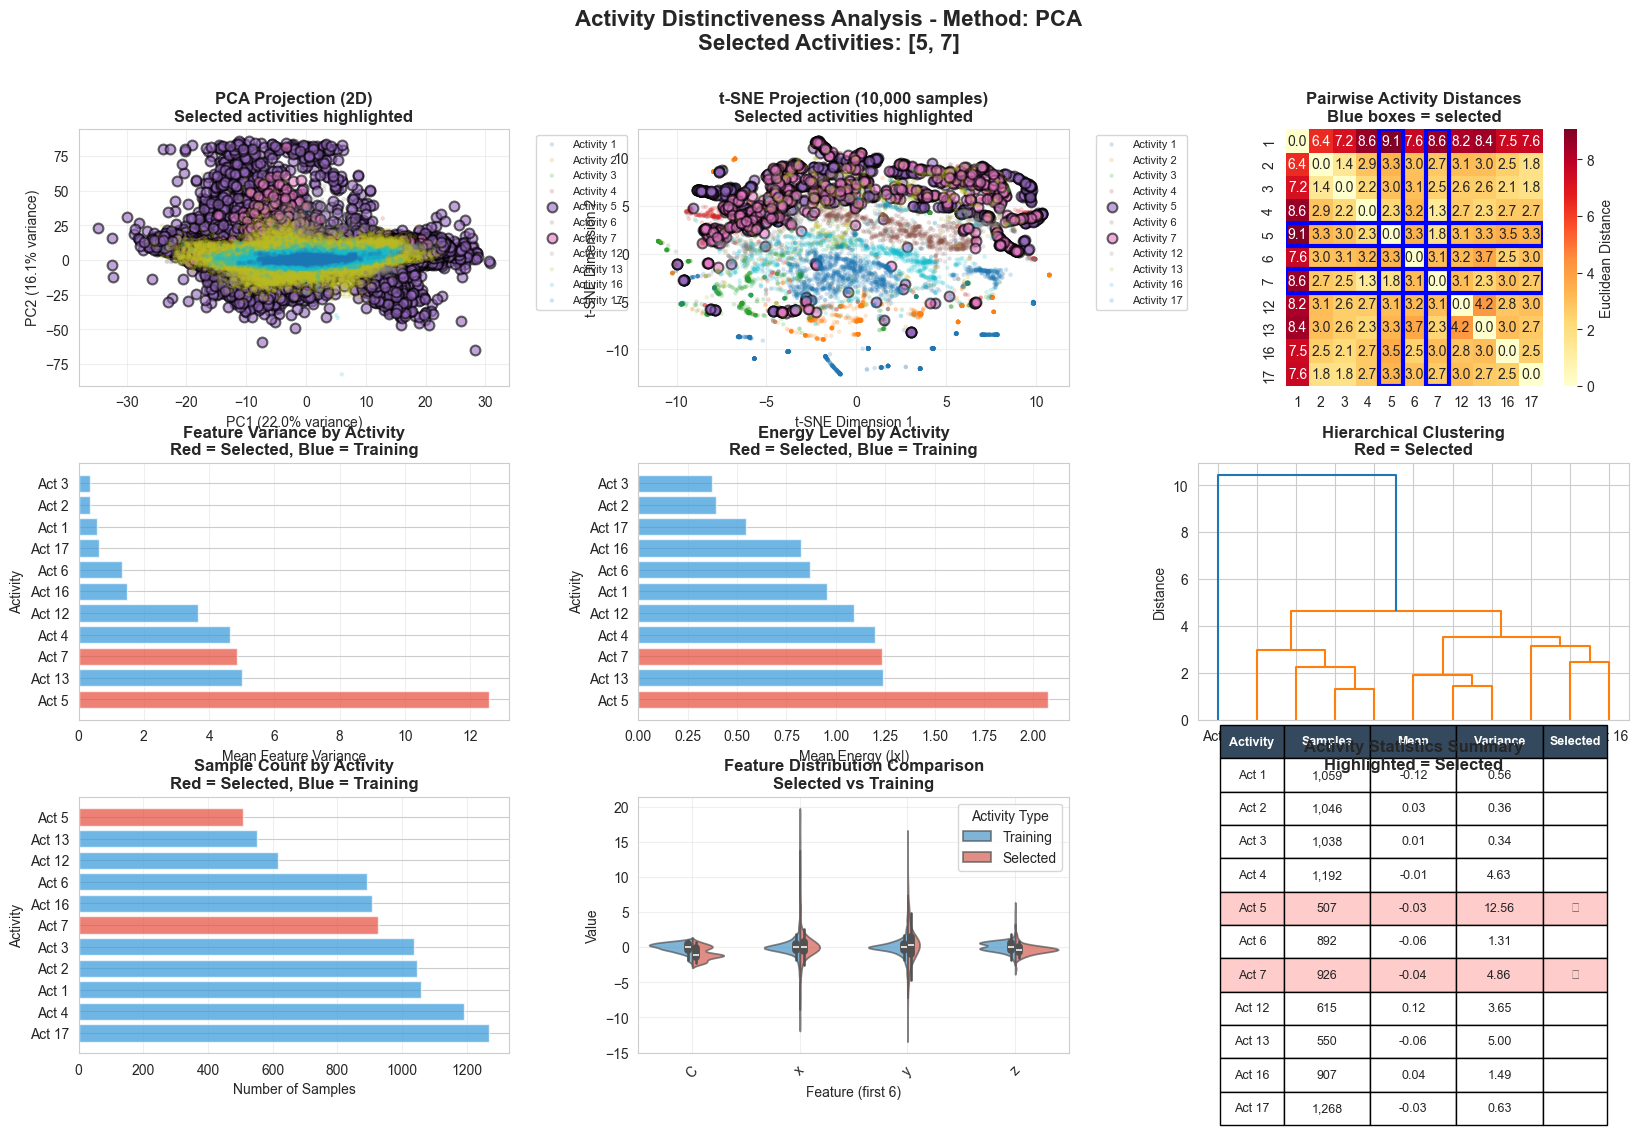

📊 Generating 3D activity space...


C:\Users\VDUART10\AppData\Local\Temp\ipykernel_30132\85371749.py:119: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\VDUART10\AppData\Local\Temp\ipykernel_30132\85371749.py:123: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig(filepath, dpi=300, bbox_inches="tight")


📊 3D plot saved to: ..\data\PAMAP2\visualizations\activity_space_3d.png


c:\Users\VDUART10\Desktop\TCC-1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


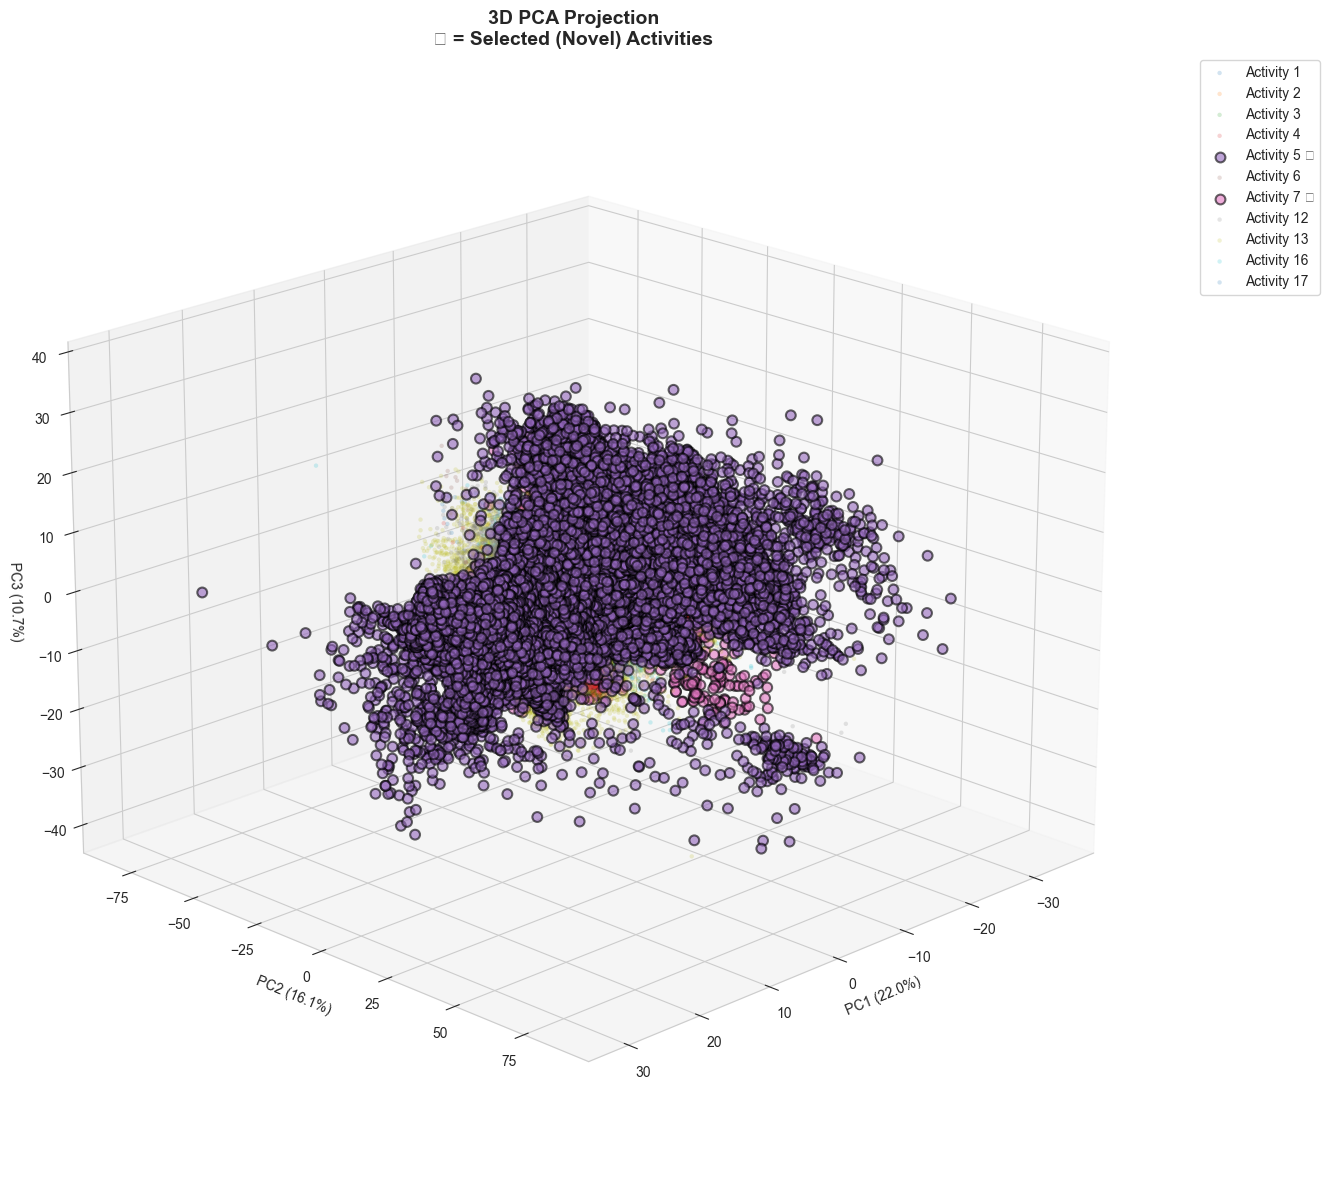

📊 Generating radar chart comparison...
📊 Radar plot saved to: ..\data\PAMAP2\visualizations\activity_radar_comparison.png


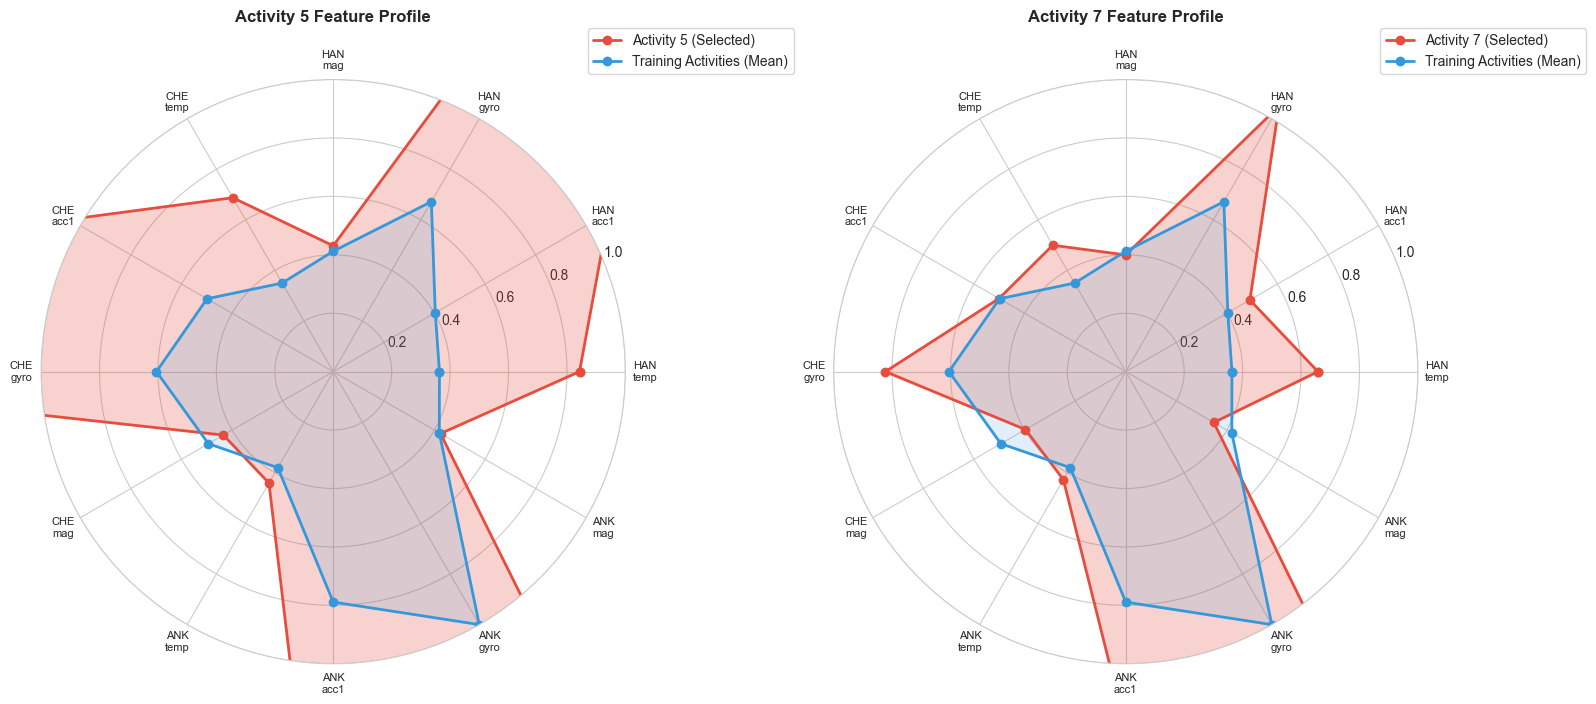

In [11]:
selected_activities = sorted(y_test["activity"].unique().tolist())
method = "pca"

output_dir = Path("../data/PAMAP2/visualizations/")
output_dir.mkdir(parents=True, exist_ok=True)

print("📊 Generating comprehensive distinctiveness analysis...")
plot_activity_distinctiveness(data, labels, selected_activities, method, output_dir)

print("📊 Generating 3D activity space...")
plot_3d_activity_space(data, labels, selected_activities, output_dir)

print("📊 Generating radar chart comparison...")
plot_activity_comparison_radar(data, labels, selected_activities, output_dir)